# **Tarea: Método de Iteración y Ecuación de Bellman**

## Alumno: José de Jesús Hernández Higuera

### Matrícula: 224470489

**Objetivo**

Implementar y analizar el método de iteración para estimar la función de valor de la acción en un entorno de Gymnasium. Comparar los resultados obtenidos con diferentes políticas y discutir la convergencia.

**Descripción**

El método de iteración para estimar el valor de la acción (Policy Iteration) es un algoritmo fundamental en el aprendizaje por refuerzo para encontrar la política óptima en un proceso de decisión de Markov (MDP). 

En esta tarea deberás: Implementar el método de iteración para estimar el valor de la acción Q(s,a) para una política fija π. Aplicar tu implementación a un entorno simple de Gymnasium (por ejemplo, FrozenLake-v1 o un entorno similar).Verificar la convergencia del algoritmo y analizar el comportamiento del valor estimado con diferentes políticas iniciales.Documentar tus resultados en un reporte que incluya código, análisis de resultados y conclusiones.

**Requerimientos específicos:**

1. Implementación
    - Implementa la iteración del valor para la función Q
    - Utiliza estructuras claras y comentadas en Python.
    - Usa la API de Gymnasium para interactuar con el entorno.

2. Entorno
    - Usar el entorno FrozenLake-v1 con la opción is_slippery=False para simplificar el modelo.
    - Definir una política inicial (por ejemplo, política aleatoria uniforme).
    - Estimar las funciones de valor Q con la política dada.

3. Análisis
    - Define un criterio de convergencia (por ejemplo, cambio máximo en Q menor que un epsilon).
    - Muestra la evolución de la convergencia (gráficos de la diferencia entre iteraciones).
    - Compara los valores Q para diferentes políticas iniciales y discute resultados.



In [ ]:
import typing as tt
import gymnasium as gym
import numpy as np
from collections import defaultdict, Counter
from torch.utils.tensorboard.writer import SummaryWriter
import matplotlib.pyplot as plt

ENV_NAME = "FrozenLake-v1"  # Entorno
GAMMA = 0.9     # Factor de descuento
TEST_EPISODES = 20      # Número de episodios

State = int     # Tanto la acción como el estado son números enteros
Action = int
RewardKey = tt.Tuple[State, Action, State]      # Clave para la tabla de recompensas
TransitKey = tt.Tuple[State, Action]        # Clave para la tabla de transiciones


In [ ]:
# Clase que definirá al agente
class Agent:
    # Definimos el inicializador. La política por default será la aleatoria uniforme
    def __init__(self, policy="random_uniform"):
        self.env = gym.make(ENV_NAME, is_slippery=False)   # Inicializa el ambiente evitando que el agente resbale
        self.policy = policy    # Politica a seguir durante el entrenamiento
        self.state, _ = self.env.reset()    # Reinicia el entorno y devuelve el estado inicial
        self.rewards: tt.Dict[RewardKey, float] = defaultdict(float)    # Tabla de recompensas
        self.transits: tt.Dict[TransitKey, Counter] = defaultdict(Counter)  # Tabla de transiciones
        self.values: tt.Dict[TransitKey, float] = defaultdict(float)    # Tabla de valores 

    # Método para ganar experiencia al aprender
    def play_n_random_steps(self, n: int):
        for _ in range(n):
            # Elegimos una política
            if self.policy == "random_uniform":
                action = self.env.action_space.sample()     # Todas las acciones son igual de probables
            elif self.policy == "greedy_initial":
                if np.random.rand() < 0.5:  # El agente explora el 50% de las veces
                    action = self.env.action_space.sample()     # Misma política que la anterior
                else:
                    action = self.select_action(self.state)     # Eploración
            elif self.policy == "always_right":
                action = 2      # Elige ir siempre a la derecha

            new_state, reward, is_done, is_trunc, _ = self.env.step(action) # Obtenemos la información después de dar un paso
            rw_key = (self.state, action, new_state)        # Tupla (clave) para la tabla de recompensas
            self.rewards[rw_key] = float(reward)        # Recompensa inmediata (valor)
            
            tr_key = (self.state, action)       # Tupla (clave) para la tabla de transiciones
            self.transits[tr_key][new_state] += 1       # Contamos el número de veces que aparece cada estado

            # Si el proceso se acaba o se trunca, reiniciamos el estado...
            if is_done or is_trunc:
                self.state, _ = self.env.reset()
            # de lo contrario, continuamos el proceso actualizando el estado
            else:
                self.state = new_state

    # Método para seleccionar la mejor acción
    def select_action(self, state: State) -> Action:
        best_action, best_value = None, None    # Al principio, la mejor acción y el mejor valor están vacíos

        for action in range(self.env.action_space.n):
            action_value = self.values[(state, action)]     # Extraemos el valor correspondiente a la tupla
            if best_value is None or best_value < action_value:     # Condición para actualizar el mejor valor
                best_value = action_value       # Nuevo mejor valor
                best_action = action        # Nueva mejor acción
        return best_action
    
    # Método para simular episodios de prueba y obtener la recompensa total asociada
    def play_episode(self, env: gym.Env) -> float:
        total_reward = 0.0      # La recomepnsa total inicial es 0
        state, _ = env.reset()

        while True:
            action = self.select_action(state)      # Seleccionamos la mejor acción para el estado
            new_state, reward, is_done, is_trunc, _ = env.step(action)      # Obtenemos la información después de dar un paso
            rw_key = (state, action, new_state)
            self.rewards[rw_key] = float(reward)
            tr_key = (state, action)
            self.transits[tr_key][new_state] += 1
            total_reward += reward 
            
            if is_done or is_trunc:
                break
            state = new_state
        return total_reward
    
    # Método para realizar la iteración de valor
    def value_iteration(self):
        max_delta = 0.0     # Mide el cambio en los valores Q(s,a)
        epsilon = 1e-4      # Umbral para la convergencia
        
        # Buscamos evaluar cada estado y cada acción del espacio de estados y acciones, respectivamente
        for state in range(self.env.observation_space.n):
            for action in range(self.env.action_space.n):
                action_value = 0.0      # El valor de la acción empieza en cero
                target_counts = self.transits[(state, action)]      # Obtenemos el valor de la tabla de transiciones
                total = sum(target_counts.values())     # Calculamos el total del conteo de los estados
                old_value = self.values[(state, action)]        # Guardamos el valor antiguo

                # Descomponemos target_counts en estado objetivo y su conteo
                for tgt_state, count in target_counts.items():
                    rw_key = (state, action, tgt_state)
                    reward = self.rewards[rw_key]
                    best_action = self.select_action(tgt_state)     # Extraemos la mejor acción para el estado objetivo
                    val = reward + GAMMA * self.values[(tgt_state, best_action)]        # Ecuación de Bellman
                    action_value += (count / total) * val       # Valor de la acción (proporcional al total)
                
                delta = abs(action_value - old_value)       # Calcula la diferencia entre el valor actual y el pasado de la acción
                max_delta = max(max_delta, delta)   # Valor máximo para el cambio en Q
                self.values[(state, action)] = action_value     # Actualiza el valor de la función Q(s,a)
        
        print(f"Delta máximo = {max_delta}")        # Visualización del máximo valor de delta
        return max_delta < epsilon, max_delta       # Regresamos un booleano y el valor máximo de delta

In [ ]:
if __name__ == "__main__":
    test_env = gym.make(ENV_NAME, is_slippery=False)        # Entorno (no permite que el agente resbale)
    policies = ["random_uniform", "greedy_initial", "always_right"]     # Probaremos 3 políticas distintas
    delta_histories = {}    # Diccionario para almacenar los máximos valores de delta para cada política
    reward_histories = {}       # Diccionario para almacenar ña recompensa de cada política
    
    for p in policies:
        delta_history= []       # Lista para almacenar los máximos valores de delta en cada iteración
        reward_history = []     # Lista para almacenar la recompensa en cada iteración
        print(f"\nEjecutando política {p}")     # Visualizamos qué política estamos ocupando
        agent = Agent(policy=p)     # Definimos al agente que seguirá la política correspondiente al ciclo for
        writer = SummaryWriter(comment="-q-iteration")

        iter_no = 0     # Comenzamos en la iteración 0
        best_reward = 0.0       # La mejor recompensa al principio es 0

        while True:
            iter_no += 1        # Vamos aumentando el número de iteración en una unidad
            agent.play_n_random_steps(500)  # Cantidad de pasos para la exploración
            converged, max_delta = agent.value_iteration()      # Extraemos los valores resultantes del método
            reward = 0.0    # La recompensa al inicio debe ser 0

            for _ in range(TEST_EPISODES):
                reward += agent.play_episode(test_env)      # Acumulamos la recompensa total de los episodios
            
            reward /= TEST_EPISODES     # Dividimos la recompensa total entre el número de epsodios
            delta_history.append(max_delta)     # Guardamos el delta máximo en la lista correspondiente
            reward_history.append(reward)       # Guardamos la recompensa en la lista correspondiente

            # Condición para actualizar la mejor recompensa
            if reward > best_reward:
                print(f"{iter_no}: Mejor recompensa actualizada "
                    f"{best_reward:.3} -> {reward:.3}")
                best_reward = reward
            
            # Condición para frenar el proceso si la recompensa es mayor a un umbral
            if reward > 0.80:
                print(f"Resuelto en {iter_no} iteraciones")
                break

            # Condición para finalizar el proceso si el valor del cambio en Q convergió
            if converged:
                print("Criterio de convergencia alcanzado")
                break

        delta_histories[p] = delta_history
        reward_histories[p] = reward_history
        writer.close()


Ejecutando política random_uniform
Delta máximo = 1.0
Delta máximo = 0.9
Delta máximo = 0.81
Delta máximo = 0.7290000000000001
Delta máximo = 0.6561000000000001
Delta máximo = 0.5904900000000002
6: Mejor recompensa actualizada 0.0 -> 1.0
Resuelto en 6 iteraciones

Ejecutando política greedy_initial
Delta máximo = 1.0
Delta máximo = 0.9
Delta máximo = 0.81
Delta máximo = 0.81
Delta máximo = 0.6561000000000001
Delta máximo = 0.6561000000000001
6: Mejor recompensa actualizada 0.0 -> 1.0
Resuelto en 6 iteraciones

Ejecutando política always_right
Delta máximo = 0.0
Criterio de convergencia alcanzado


---

# **Reporte: Método de iteración y ecuación de Bellman**

## Explicación del método teórico

### Método de iteración de valor

El método de la iteración de valor es un algoritmo utilizado en el aprendizaje por refuerzo para encontrar una política óptima. Este proceso nos permite calcular numéricamente los valores de los estados y de las acciones de un Proceso de Decisión de Markov (MDP) con una transición de probabilidades y recompensas conocidas, esto es, el entorno asociado debe de poder modelarse como un MDP para poder aplicar el método en cuestión. El procedimiento para llevarlo a cabo es el siguiente:

1. Inicializar los valores de todos los estados asignándoles un valor inicial (por lo general, el cero).
2. Para cada estado del MDP, el valor se debe actualizar por medio de la ecuación de Bellman:

\begin{equation*}
    V(s) \leftarrow \max_a \sum_{s'} P(s'|s,a) \left[ R(s,a,s') + \gamma V(s') \right]
\end{equation*}

3. Repetimos el paso anterior hasta que los cambios entre los valores se vuelvan muy pequeños como para ser significativos, es decir, hasta que sean menores que un umbral, $\varepsilon$, definido.

Si bien esta definición está en terminos de la función de valor del estado $V(s)$, se sabe perfectamente que existe una versión de la ecuación de Bellman para la función de valor del estado y de la acción, es decir, la función Q:

\begin{equation*}
    Q(s,a) \leftarrow \mathbb{E}_{s'}\big[ R(s,a,s') + \gamma \max_{a'} Q(s',a') \big]
\end{equation*}

Veremos entonces que el mprocedimiento a seguir es bastante similar al anterior, pero con algunas adaptaciones a la ecuación correspondiente:

1. Inicializar la función $Q(s,a)$ (por ejemplo, con ceros, como se dijo antes).
2. Recolectar las transiciones $(s,a,r,s')$ mediante una política inicial.
3. Para cada par $(s,a)$, usar la ecuación anterior para actualizar el valor de la función Q.
4. Repetir el proceso desde el paso 2 hasta que el cambio máximo entre las iteraciones sea menor que un umbral $\varepsilon$.

De manera más concreta, en el último paso, sea $\Delta$ el cambio máximo entre el valor nuevo y el viejo de la función Q(s,a), entonces:

\begin{equation*}
    \Delta = \max_{s,a} |Q_{\text{new}}(s,a) - Q_{\text{old}}(s,a)|,
\end{equation*}

la condición de parada para dejar de iterar estaría dada por:

\begin{equation*}
    \Delta < \varepsilon
\end{equation*}



### FrozenLake

Para este caso en particular, el entorno *FrozenLake* se modela como un MDP discreto con un conjunto finito de estados y acciones. En *FrozenLake* cada una de las celdas corresponde a un estado enumerado del 1 (casilla inicial) al 16 (casilla fianl). Las acciones a realizar aquí simplemente corresponden a las direcciones en las cuales podríamos caminar en un videojuego (arriba, izquierda, derecha, abajo). Existen agujeros en los cuales nuestro personaje (el agente) puede caer y terminar la partida. Adicionalmente, para aumentar la dificultad, el agente tiene un 33% de resbalar terminando en una casilla en una dirección completamente diferente a aquella a la que se dirigía inicialmente, haciendo así que las acciones puedan ser algo inesperadas. Por default, esta configuración estará presente a menos que se especifique que se desactive, en cuyo caso hará que quede un sistema completamente determinista y, en consecuencia, que la convergencia se alcance más rápido. El objetivo dentro de este entorno es encontrar el camino que nos lleve a la casilla final para obtener una recompensa.


## Descripción de la implementación

Con el objetivo de mantener un orden visual más cómodo, así como depurar los errores en el código de manera más eficaz, el presente código se dividirá en 3 partes:<br>
- Importación de librerías y definición de variables
- Definición de los métodos del agente
- Prueba

A continuación, se explicará detalladamente la forma en la que se ha construido el código con base en la teoría descrita en el apartado anterior.

### Importación de librerías y definición de variables

Para comenzar, se crearon las partes más básicas del código para implementar el entorno *Frozen Lake* de Gymnasium. Primero que nada, se importaron las librerías (como *typing*, *gymnasium* o *numpy*) y las funciones que se utilizaron en las celdas posteriores. Luego, se definieron las variables que describen al entorno, el factor de descuento y el número de episodios para entrenar el algoritmo. Finalmente, se determinó que tanto los estados como las acciones serán variables de tipo entero y se utilizarán para obtener el valor de la acción. Para ello, se requieren los siguientes diccionarios:

- **Tabla de recompensas**: donde la clave será una tupla conformada por el estado de origen, la acción y el nuevo estado, y el valor será la recompensa inmediata.
- **Tabla de transiciones**: donde la clave estará compuesta por una tupla que contendrá al estado y a la acción, y el valor es otro diccionario que contará el número de veces que la acción aplicada llevó a un estado específico, esto es, la clave de este nuevo diccionario será el nuevo estado y el valor es el número de veces que se observó.

Con esto en mente, las últimas dos variables a las que se hacen referencia en la primera celda son las claves de los respectivos diccionarios descritos anteriormente.

### Definición de los métodos del agente

La segunda celda hace referencia a la definición de la clase que conforma al agente y lleva por nombre *Agent*. En lo siguiente, se describirá cada uno de los métodos presentes dentro de la clase, sus respectivas variables y su funcionalidad.

- `__init__`

Como bien se sabe, este método, en general, es el constructor de las variables definidas dentro de él. Como argumento de este método nos encontramos con *self* (palabra reservada para hacer referencia al objeto que tendrá las propiedades descritas por la clase) y *policy*, la cual, en caso de no ser especificada, tomará *"random_uniform"* como valor por default. El argumento *policy* es el que nos permitirá llevar a cabo alguna política que seguirá el agente. La política contenida como valor por default corresponde a aquella en la que todas las direcciones son igualmente probables.

Dentro del constructor encontraremos las variables: *env* donde colocamos la variable que contiene el entorno que se usarán para las pruebas (y que se determinó en la primera celda) junto con la opción `is_slippery=False`, evitando así que el agente resbale en el tablero; *policy* para determinar la política a seguir, *state* donde el método contenido en esta reinicia el entorno y devuelve el estado inicial y la información del mismo (la cual es ignorada mediante el carácter '_'); *rewards* que contiene la tabla de recompensas (un diccionario), *transits* que es la tabla de transiciones y *values* que hace referencia a la tabla de valores de las acciones y los estados (Q(s,a)).

- `play_n_random_steps`

En este método creamos un ciclo *for* para iterar el número de pasos especificado en el argumento del mismo (n). En primer lugar, se toma la política especificada en el método anterior y, según sea el caso, tomaremos las acciones correspondientes. Sólo hay tres opciones: *random_uniform*, *greedy_initial* (donde el agente seguirá la primera política la mitad de las veces, y la otra mitad hará exploración) y *always_right* (el agente siempre irá a la derecha. Esto se representa con el número 2).

En segundo lugar, obtenemos la información del sistema después de haber dado un paso por medio del método `step()`. Nos interesa obtener el nuevo estado que se alcanzó, la recompensa asociada a ello y si el procedimiento ha finalizado o se ha truncado. El estado inicial, la acción realizada y el nuevo estado nos sirven para actualizar el valor de la recompensa inmediata en la tabla de recompensas (*rewards*). Por otra parte, el estado inicial y la acción nos ayudan para este mismo fin pero en la tabla de transiciones, en donde, al mismo tiempo, se actualiza un nuevo diccionario donde llevaremos la cuenta de cuántas veces aparece el mismo nuevo estado partiendo del estado inicial y ejecutando la acción descrita. Finalmente, si el proceso se ha detenido por alguna de las dos razones dichas anteriormente, el entorno se reiniciará, de lo contrario, el nuevo estado pasará a ser el estado actual y el ciclo *for* continuará con otra iteración.

- `select_action`

En esta sección haremos que el código elija la mejor acción posible. De principio, desde luego, la mejor acción y el mejor valor (asociado a la misma) no existen, esto es, las variables están vacías. Luego, al iterar en el espacio de acciones, podemos ir obteniendo el valor de las acciones directamente de la tabla de valores y, a su vez, compararlo con el resto para determinar cuál de las acciones tiene un mayor valor. En consecuencia, esto implica encontrar la mejor acción.

- `play episode`

Esta parte del código sirve para simular episodios de prueba y obtener la recompensa total asociada a los mismos. Al principio, como se espera, la recompensa total vale cero y se comienza desde la casilla de inicio del entorno. El método en sí no es muy distino a `play_n_random_steps`, de hecho hay partes de este mismo que se repiten aquí (exceptuando la parte de la política) en un cíclo *while*. La diferencia radica en que, en el presente método se irá acumulando la recompensa obtenida en cada iteración en una variable que será devuelta e interpretada como la recompensa total.

- `value_iteration`

Por último, el método de la iteración de valor es el más importante, ya que en este se describe el procedimiento homónimo. En este, buscamos obtener el valor de la función Q por medio de la ecuación de Bellman en cada iteración. A este proceso le añadimos un umbral, pues buscamos comparar que tan diferentes son los valores de la función, es decir, cuando el valor absoluto de la diferencia entre el valor anterior y el actual de la función Q sea menor que el umbral podemos considerar que el agente ya no mejorará la recompensa y, por lo tanto, detenemos las iteraciones.

Tomando lo anterior en cuenta, lo primero que se define es el cambio inicial como cero y el umbral requerido para la convergencia. Luego, será necesario iterar sobre todos los estados y las acciones. El valor de la acción se obtendrá más adelante y se hará proporcional al total, de modo que al principio debe de empezar siendo cero. Usando el estado y la acción, podemos obtener el valor de la función Q directamente de la tabla de valores. Por otra parte, con esto mismo podemos obtener la acción futura junto con su respectiva acción para poder calcular el nuevo valor de la función Q mediante la Ecuación de Bellman. Este valor debe ser proporcional al total, de modo que así es como se actualiza el valor correspondiente a la acción. 

Una vez terminado este proceso, se debe realizar la comparación entre el valor de la acción y el atiguo valor de Q. A esta diferencia le llamamos delta. Dado que el cambio máximo entre estos valores será lo que nos servirá para establecer el criterio de convergencia, es necesario asegurarnos de elegirlo explícitamente. Por último, actualizamos el valor de la función Q(s,a) para las siguientes iteraciones y devolvemos dos resultados: un booleano que determina si el criterio de la convergencia fue alcanzado o no, y el máximo valor de delta. Cabe resaltar que, para obtener los resultados que se observan en la salida de la celda, fue necesario correr el código varias veces ya que había ocasiones donde ninguna de las políticas daban resultados o sólo una de ellas lo hacía. Este fue el resultado más satisfactorio de todos lo que aparecieron.

### Prueba

La parte correspondiente a las pruebas del código comienza con la definición de cuatro variables que se usan en el resto de la celda. Dichas variables hacen referencia al entorno que se manejará (donde nuevamente se tiene que mencionar la opción para evitar que el agente resbale), las políticas que se intentarán (dentro de una lista) y un par de diccionarios que representarán los máximos valores de delta detectados en cada iteración y los valores de las recompensas. En ambos casos se guardarán estos datos correspondientes a cada política. Para poder hacer lo anterior, desde luego, se tiene que iterar en el diccionario de políticas. Además, para llevar un registro más detallado, se comienza con el número de iteraciones y la mejor recompensa como cero. 

Con lo anterior ya construido, se procede a realizar iteraciones donde apliquemos los métodos construidos para el agente. Primero se realizó el entrenamiento del agente aplicando 500 pasos para realizar la exploración. Luego, se hizo la iteración de valores, la acumulación de la recompensa total y se guardaron los valores máximos de delta y la recompensa en sus listas correspondientes para, posteriormente, poder visualizarlos mediante una gráfica. Finalmente se estableció la condición para actualizar las recompensas (cuando la recompensa es mejor que la recompensa anterior), para frenar el procedimiento si la recompensa es mayor a 0.8 y para hacer esto mismo si el valor de Q ha convergido. 

## Resultados y gráficos

Tras ejecutar la tercera celda, es decir, la correspondiente a la prueba, se han obtenido los siguientes resultados:

<i>
Ejecutando política random_uniform <br>
Delta máximo = 1.0 <br> 
Delta máximo = 0.9 <br>
Delta máximo = 0.81 <br>
Delta máximo = 0.7290000000000001 <br> 
Delta máximo = 0.6561000000000001 <br>
Delta máximo = 0.5904900000000002 <br>
6: Mejor recompensa actualizada 0.0 -> 1.0 <br>
Resuelto en 6 iteraciones <br>

Ejecutando política greedy_initial <br>
Delta máximo = 1.0 <br>
Delta máximo = 0.9 <br>
Delta máximo = 0.81 <br>
Delta máximo = 0.81 <br>
Delta máximo = 0.6561000000000001 <br>
Delta máximo = 0.6561000000000001 <br>
6: Mejor recompensa actualizada 0.0 -> 1.0 <br>
Resuelto en 6 iteraciones <br>

Ejecutando política always_right <br>
Delta máximo = 0.0 <br>
Criterio de convergencia alcanzado
</i>

Tomando esta información, a continuación veremos el código utilizado para construir los gráficos donde se representa la convergencia de la función $Q(s,a)$ con respecto al número de iteraciones (Figura 1) y la recompensa alcanzada (Figura 2). En ambos casos, se hacen distinciones para resaltar cada una de las políticas utilizadas para realizar las pruebas.

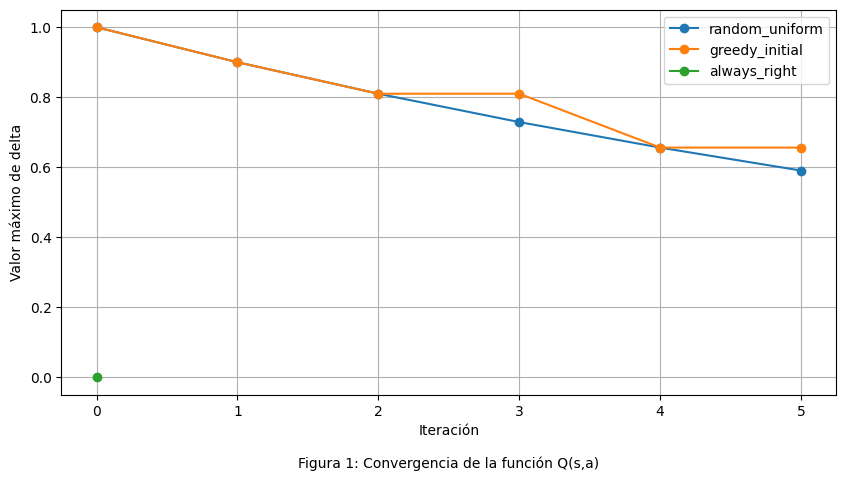

In [ ]:
plt.figure(figsize=(10,5))
for policy, deltas in delta_histories.items():
    plt.plot(deltas, label=policy, marker='o')
plt.xlabel("Iteración\n\nFigura 1: Convergencia de la función Q(s,a)")
plt.ylabel("Valor máximo de delta")
plt.grid()
plt.legend()
plt.show()

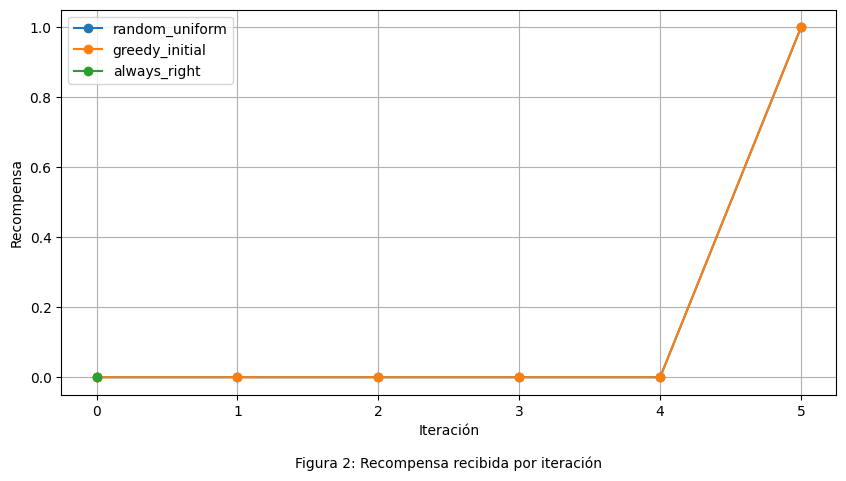

In [ ]:
plt.figure(figsize=(10,5))
for policy, rewards in reward_histories.items():
    plt.plot(rewards, label=policy, marker='o')
plt.xlabel("Iteración\n\nFigura 2: Recompensa recibida por iteración")
plt.ylabel("Recompensa")
plt.grid()
plt.legend()
plt.show()

## Análisis y conclusiones

En la sección anterior podemos apreciar que únicamente las políticas *random uniform* y *greedy initial* fueron capaces de terminar el proceso satisfactoriamente. Notamos también que, para las dos políticas que produjeron resultados, el valor máximo para el cambio de la función $Q(s,a)$ ($\Delta$) tiene un comportamiento decreciente, lo cual es congruente con el hecho de que este velor debe decaer hasta alcanzar el criterio de convergencia establecido en el código ($\varepsilon = 1 \times 10^{-4}$). A su vez, este mismo comportamiento se aprecia en la figura 1 de la sección de gráficos. Si bien en *greedy initial* se repiten algunos de los valores, se puede ver cómo ambas políticas tienen una tendencia a hacer que el valor $\Delta$ decaiga. Por otra parte, ambas políticas alcanzan la máxima recompensa esperada que es de 1, mientras que la política *always right* mantiene su recompensa como cero debido a que no pudo concretar el proceso alcanzando la casilla final. Por supuesto, este mismo comportamiento se puede apreciar en la figura 2 de la sección de gráficos y resultados.

Podemos concluir que las políticas *random uniform* y *greedy initial* fueron capaces de alcanzar la casilla final y de reproducir el comportamiento esperado en cuanto al cambio máximo de la función de valor del estado y la acción. Sin embargo, la política *always right* no fue capaz de poder realizar ninguna iteración, lo cual sugiere que dentro del entorno hay una pared o un agujero en el primer giro que el agente da a la derecha, lo cual hace que la partida termine sin poder siquiera hacer la primera iteración. Cambiar el valor de la frecuencia con la que la política *greedy initial* hace exploración, así como otras políticas basadas en cambios de direcciones distintas a la política *always right*, serían sugerencias interesantes para evaluar en dentro de este mismo código.